In [4]:
#standard
import os
import warnings
warnings.filterwarnings('ignore')
import pickle

#third party
import numpy as np
import hcp_utils as hcp
from nilearn import plotting
import matplotlib.pyplot as plt

In [2]:
def calculate_noiseceiling(betas, n: int=1):
    """
    Calculate the standard deviation across trials, square the result,
    average across images, and then take the square root. The result is
    the estimate of the 'noise standard deviation'. 
    Parameters:
    betas: beta estimates in shape (vertices, num_reps, num_stimuli)
    Returns:
    ncsnr: noise-ceiling SNR at each voxel in shape (voxel_x, voxel_y, voxel_z) as ratio between signal std and noise std
    noiseceiling: noise ceiling at each voxel in shape (voxel_x, voxel_y, voxel_z) as % of explainable variance 
    Code adapted from GLMsingle example: https://github.com/cvnlab/GLMsingle/blob/main/examples/example9_noiseceiling.ipynb
    """
    assert(len(betas.shape) == 3)
    numvertices = betas.shape[0]
    num_reps = betas.shape[1]
    num_vids = betas.shape[2]
    noisesd = np.sqrt(np.mean(np.power(np.std(betas,axis=1,keepdims=1,ddof=1),2),axis=2)).reshape((numvertices,))

    # Calculate the total variance of the single-trial betas.
    totalvar = np.power(np.std(np.reshape(betas, (numvertices , num_reps*num_vids)), axis=1),2)

    # Estimate the signal variance and positively rectify.
    signalvar = totalvar - np.power(noisesd,2)

    signalvar[signalvar < 0] = 0
    # Compute ncsnr as the ratio between signal standard deviation and noise standard deviation.
    ncsnr = np.sqrt(signalvar) / noisesd

    # Compute noise ceiling in units of percentage of explainable variance
    noiseceiling = 100 * (np.power(ncsnr,2) / (np.power(ncsnr,2) + 1/n))
    return ncsnr, noiseceiling


In [6]:
#setup paths
dataset_root = "/your/path/to/BOLDMomentsDataset"
subject = 1 #which subject 1-10 you want to look at
fmri_path = os.path.join(dataset_root,"derivatives", "versionB", "fsLR32k","GLM")
subject = f"sub-{int(subject):02}"

#define subject and session. Change 'n' to get the noiseceiling for single trial (n=1) or trial average (n=3, n=10 for train, test respectively)
n_task = {'train': [1,3], 'test': [1,10]}

(102, 10, 91282)
sub-01 test n=1 max noiseceiling: 64.95318097915576


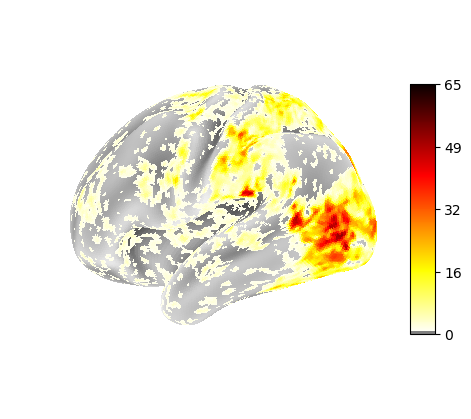

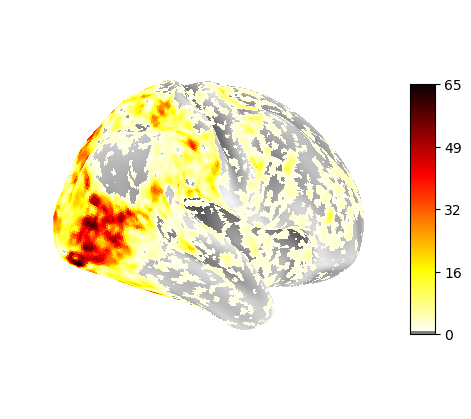

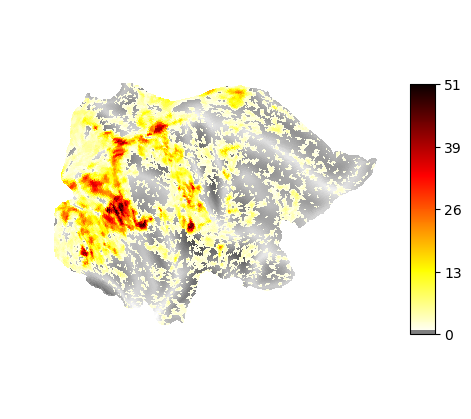

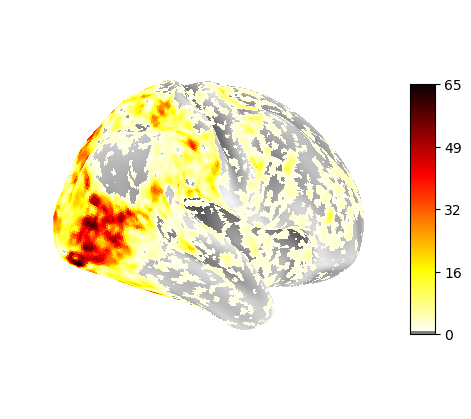

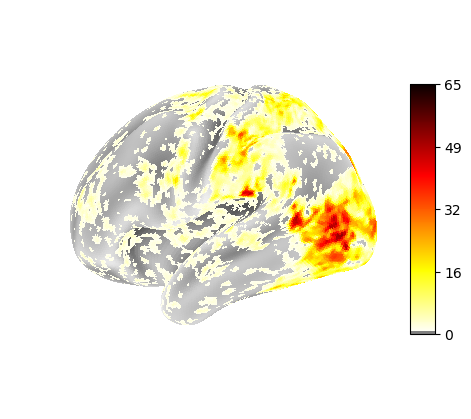

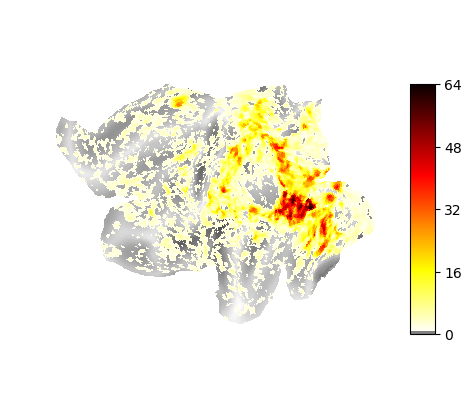

sub-01 test n=10 max noiseceiling: 94.88052686049475


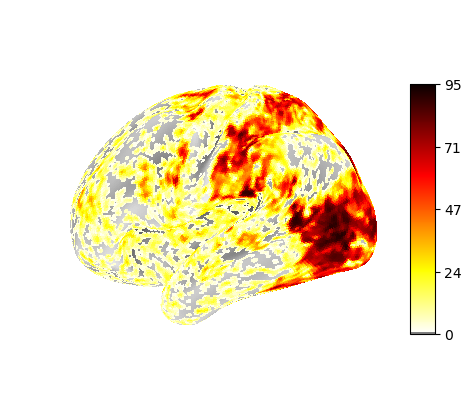

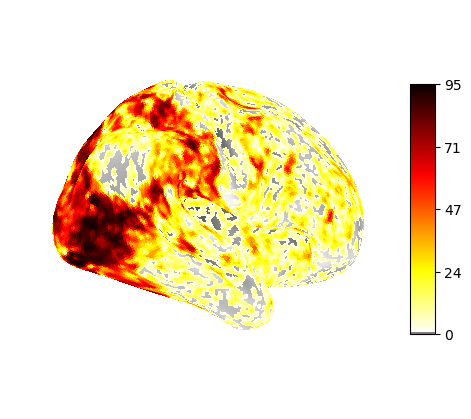

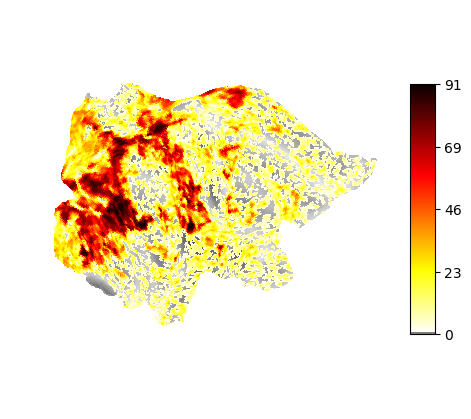

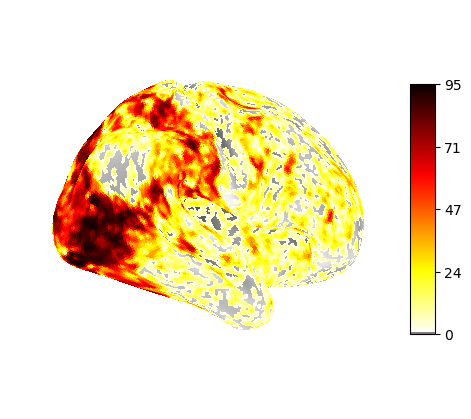

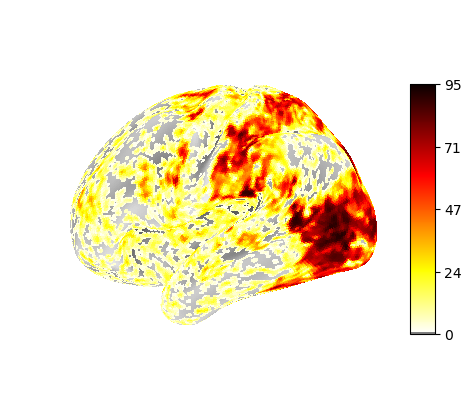

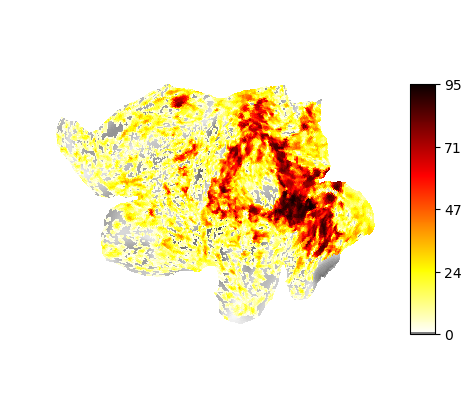

(1000, 3, 91282)
sub-01 train n=1 max noiseceiling: 63.11117812626931


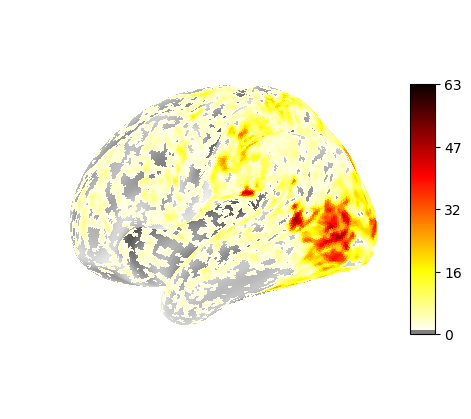

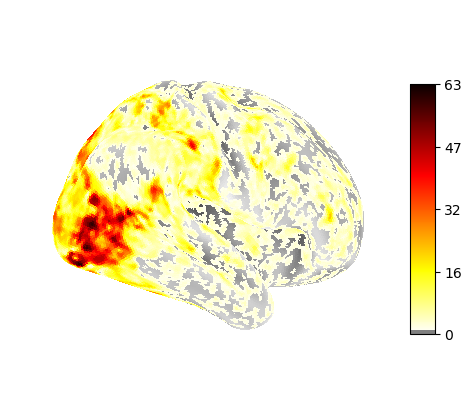

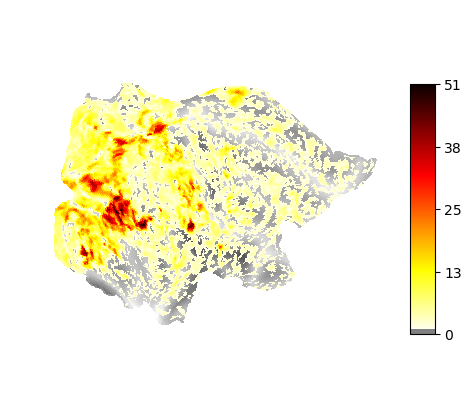

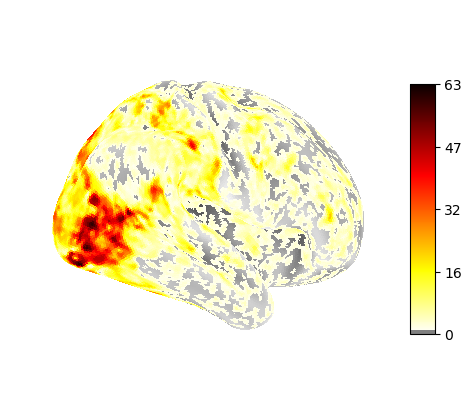

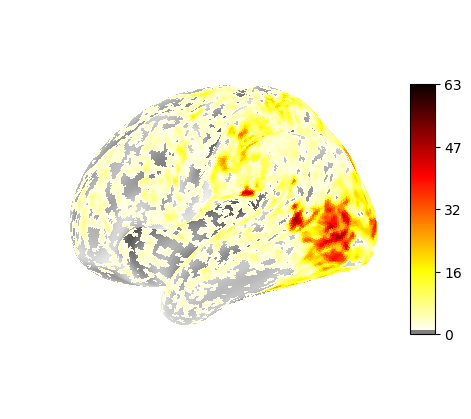

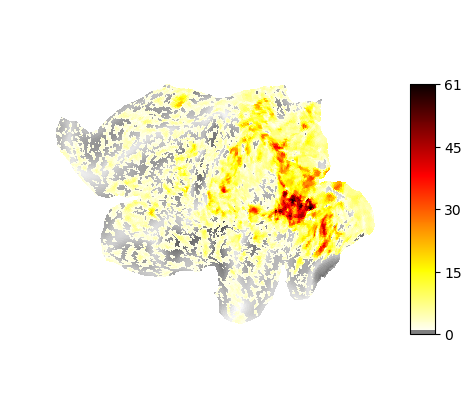

sub-01 train n=3 max noiseceiling: 83.69355598411741


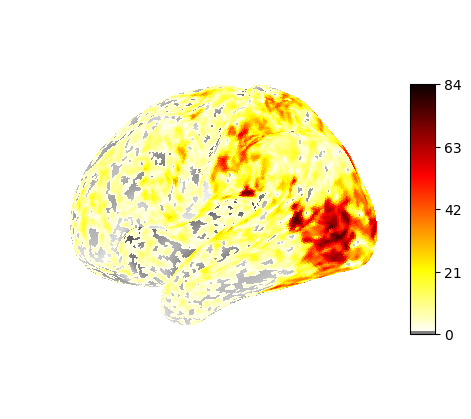

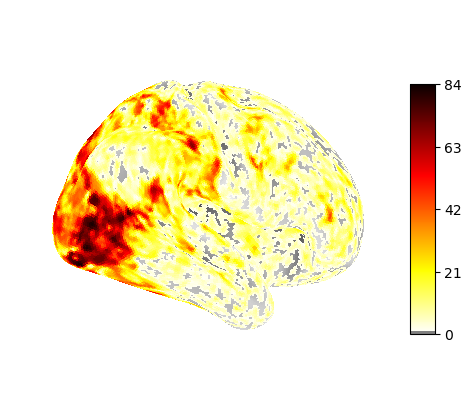

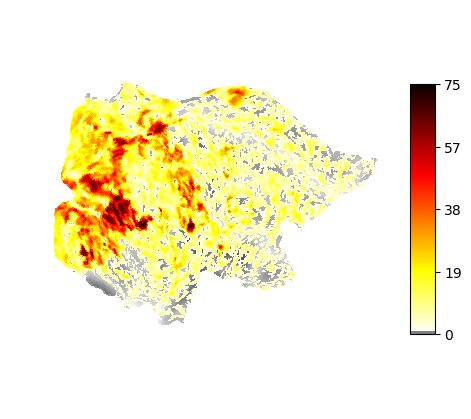

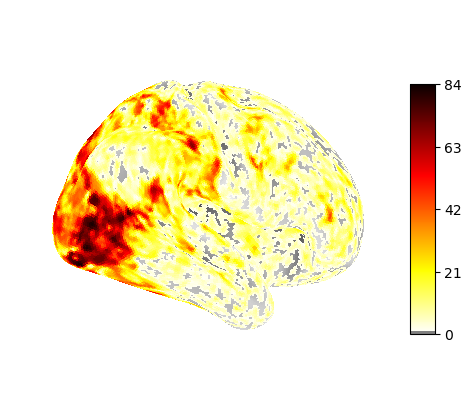

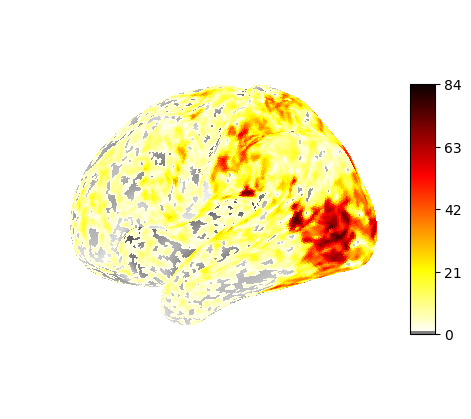

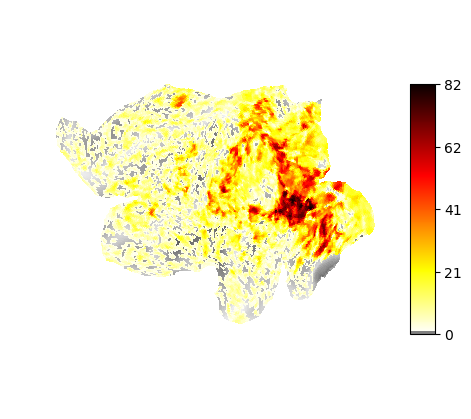

In [7]:
for task in ['test','train']:
    with open(os.path.join(fmri_path, subject, "prepared_betas", f"{subject}_organized_betas_task-{task}_normalized.pkl"), 'rb') as f:
        fmri_data, _ = pickle.load(f)
    print(fmri_data.shape)
    betas = fmri_data.T

    for n in n_task[task]:
        ncsnr, noiseceiling = calculate_noiseceiling(betas, n=n)
        print(f"{subject} {task} n={n} max noiseceiling: {np.nanmax(noiseceiling)}")
        
        views = ['lateral', 'medial'] #['lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior']
        noiseceiling[noiseceiling < 0] = 0

        stat = noiseceiling.copy()
        for hemi in ['left','right']:
            mesh = hcp.mesh.inflated
            cortex_data = hcp.cortex_data(stat)
            bg = hcp.mesh.sulc
            for view in views:
                display = plotting.plot_surf_stat_map(mesh, cortex_data, hemi=hemi,
                threshold=1, bg_map=bg, view=view, cmap='hot_r')
                plt.show()

            #flattened brain
            if hemi == 'left':
                cortex_data = hcp.left_cortex_data(stat)
                display = plotting.plot_surf(hcp.mesh.flat_left, cortex_data,
                threshold=1, bg_map=hcp.mesh.sulc_left, colorbar=True, cmap='hot_r')
                plt.show()

            if hemi == 'right':
                cortex_data = hcp.right_cortex_data(stat)
                display = plotting.plot_surf(hcp.mesh.flat_right, cortex_data,
                threshold=1, bg_map=hcp.mesh.sulc_right, colorbar=True, cmap='hot_r')
                plt.show()
